# Comparison of Uncertainty Estimation on Toy Example

In [1]:
import numpy as np
import numpy.matlib
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

from spinup.algos.uncertainty_estimate.core import MLP, BeroulliDropoutMLP, BootstrappedEnsemble, get_vars, ReplayBuffer


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Generate Training Data

In [2]:
# Target from "Deep Exploration via Bootstrapped DQN"
#   y = x + sin(alpha*(x+w)) + sin(beta*(x+w)) + w
#   w ~ N(mean=0, var=0.03**2)
#   Training set: x in (0, 0.6) or (0.8, 1), alpha=4, beta=13
def generate_label(x, noisy=True):
    num = len(x)
    alpha, beta = 4, 13
    if noisy:
        sigma = 0.03
    else:
        sigma = 0
    omega = np.random.normal(0, sigma, num)
    y = x + np.sin(alpha*(x+omega)) + np.sin(beta*(x+omega)) + omega
    return y

def plot_training_data_and_underlying_function(train_size=20, train_s1=0, train_e1=0.6, train_s2=0.8, train_e2=1.4):
    x_f = np.arange(-1, 2, 0.005)
    # True function
    y_f = generate_label(x_f, noisy=False)
    # Noisy data
    y_noisy = generate_label(x_f, noisy=True)
    # Training data
    x_train = np.concatenate((np.random.uniform(train_s1, train_e1, int(train_size/2)), np.random.uniform(train_s2, train_e2, int(train_size/2))))
    y_train = generate_label(x_train)

    plt.figure()
    plt.plot(x_f, y_f, color='k')
    plt.plot(x_f, y_noisy, '.', color='r', alpha=0.3)
    plt.plot(x_train, y_train, '.', color='b')
    plt.legend(['underlying function', 'noisy data', '{} training data'.format(train_size)])
    plt.tight_layout()
    plt.savefig('./underlying_function_for_generating_data.jpg', dpi=300)
    plt.show()
    
    return x_train, y_train, x_f, y_f

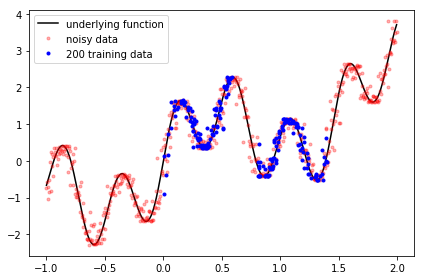

In [3]:
# sns.set(style="darkgrid", font_scale=1.5)
training_data_size = 200#20#50
x_train, y_train, x_f, y_f = plot_training_data_and_underlying_function(train_size=training_data_size,
                                                                        train_s1=0, train_e1=0.6, train_s2=0.8, train_e2=1.4)


In [4]:
x_train = x_train.reshape(-1,1)
X_train = np.concatenate([x_train, x_train**2, x_train**3], axis=1)
X_train.shape

(200, 3)

# Build Neural Networks

In [5]:
seed=0
x_dim=X_train.shape[1]
y_dim = 1
hidden_sizes = [300, 300]
x_low = -10
x_high = 10
max_steps=int(1e6)
learning_rate=1e-3
batch_size=100
replay_size=int(1e6)
BerDrop_n_post=50#100
dropout_rate = 0.05
bootstrapp_p = 0.75

In [6]:
tf.set_random_seed(seed)
np.random.seed(seed)

# Define input placeholder
x_ph = tf.placeholder(dtype=tf.float32, shape=(None, x_dim))
y_ph = tf.placeholder(dtype=tf.float32, shape=(None, y_dim))
layer_sizes = hidden_sizes + [y_dim]
hidden_activation=tf.keras.activations.relu
output_activation = tf.keras.activations.linear

In [7]:
# 1. Create MLP to learn RTN:
#       which is only used for generating target value.
mlp_replay_buffer = ReplayBuffer(x_dim=x_dim, y_dim=y_dim, size=replay_size)
with tf.variable_scope('MLP'):
    mlp = MLP(layer_sizes, hidden_activation=hidden_activation, output_activation=output_activation)
    mlp_y = mlp(x_ph)

mlp_loss = tf.reduce_mean((y_ph - mlp_y)**2) # mean-square-error
mlp_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
mlp_train_op = mlp_optimizer.minimize(mlp_loss, var_list=mlp.variables)

# 2. Create BernoulliDropoutMLP：
#       which is trained with dropout masks and regularization term
with tf.variable_scope('BernoulliDropoutUncertaintyTrain'):
    bernoulli_dropout_mlp = BeroulliDropoutMLP(layer_sizes, weight_regularizer=1e-6, dropout_rate=dropout_rate,
                                               hidden_activation = hidden_activation,
                                               output_activation = output_activation)
    ber_drop_mlp_y = bernoulli_dropout_mlp(x_ph, training=True) # Must set training=True to use dropout mask

ber_drop_mlp_reg_losses = tf.reduce_sum(
    tf.losses.get_regularization_losses(scope='BernoulliDropoutUncertaintyTrain'))
ber_drop_mlp_loss = tf.reduce_sum(
    (y_ph - ber_drop_mlp_y) ** 2 + ber_drop_mlp_reg_losses)  # TODO: heteroscedastic loss
ber_drop_mlp_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
ber_drop_mlp_train_op = ber_drop_mlp_optimizer.minimize(ber_drop_mlp_loss,
                                                        var_list=bernoulli_dropout_mlp.variables)

# 3. Create lazy BernoulliDropoutMLP:
#       which copys weights from MLP by:
#           lazy_bernoulli_dropout_mlp_sample.set_weights(mlp.get_weights())
#       then post sample predictions with dropout masks.
with tf.variable_scope('LazyBernoulliDropoutUncertaintySample'):
    lazy_bernoulli_dropout_mlp = BeroulliDropoutMLP(layer_sizes, weight_regularizer=1e-6, dropout_rate=dropout_rate,
                                                    hidden_activation=hidden_activation,
                                                    output_activation=output_activation)
    lazy_ber_drop_mlp_y = lazy_bernoulli_dropout_mlp(x_ph, training=True) # Set training=True to sample with dropout masks
    lazy_ber_drop_mlp_update = tf.group([tf.assign(v_lazy_ber_drop_mlp, v_mlp)
                                         for v_mlp, v_lazy_ber_drop_mlp in zip(mlp.variables, lazy_bernoulli_dropout_mlp.variables)])

# Create BootstrappedEnsembleNN
with tf.variable_scope('BootstrappedEnsembleUncertainty'):
    boots_ensemble = BootstrappedEnsemble(ensemble_size=BerDrop_n_post, x_dim=x_dim, y_dim=y_dim, replay_size=replay_size,
                                          x_ph=x_ph, y_ph=y_ph, layer_sizes=layer_sizes, 
                                          hidden_activation=hidden_activation,
                                          output_activation=output_activation,
                                          learning_rate=learning_rate)


Instructions for updating:
Colocations handled automatically by placer.


In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training

In [9]:
# Add training set to bootstrapped_ensemble
for i in range(X_train.shape[0]):
    boots_ensemble.add_to_replay_buffer(X_train[i], y_train[i], bootstrapp_p=bootstrapp_p)

In [10]:
training_epoches = 2000#500
ber_drop_mlp_train_std = np.zeros((training_epoches,))
ber_drop_mlp_train_loss = np.zeros((training_epoches,))

lazy_ber_drop_mlp_train_std = np.zeros((training_epoches,))
lazy_ber_drop_mlp_train_loss = np.zeros((training_epoches,))

boots_ensemble_train_std = np.zeros((training_epoches,))
boots_ensemble_train_loss = np.zeros((training_epoches,))

for ep_i in range(training_epoches):
    if ep_i%100==0:
        print('epoch {}'.format(ep_i))
    # TODO: uncertainty on training set
    #    repmat X_train for post sampling: N x BerDrop_n_post x x_dim
    ber_drop_mlp_post = np.zeros([X_train.shape[0], BerDrop_n_post, y_dim])
    lazy_ber_drop_mlp_post = np.zeros([X_train.shape[0], BerDrop_n_post, y_dim])
    boots_ensemble_post = np.zeros([X_train.shape[0], BerDrop_n_post, y_dim])
    for x_i in range(X_train.shape[0]):
        x_post = np.matlib.repmat(X_train[x_i,:], BerDrop_n_post, 1) # repmat x for post sampling
        
        # BernoulliDropoutMLP
        ber_drop_mlp_post[x_i,:,:] = sess.run(ber_drop_mlp_y, feed_dict={x_ph: x_post})

        # LazyBernoulliDropoutMLP
        lazy_ber_drop_mlp_post[x_i,:,:] = sess.run(lazy_ber_drop_mlp_y, feed_dict={x_ph: x_post})

        # BootstrappedEnsemble
        boots_ensemble_post[x_i,:,:] = boots_ensemble.prediction(sess, X_train[x_i,:]) 
    
    # Everage std on training set
    ber_drop_mlp_train_std[ep_i] = np.mean(np.std(ber_drop_mlp_post,axis=1))
    
    lazy_ber_drop_mlp_train_std[ep_i] = np.mean(np.std(lazy_ber_drop_mlp_post,axis=1))
    
    boots_ensemble_train_std[ep_i] = np.mean(np.std(boots_ensemble_post,axis=1))
    
    # Train MLP
    mlp_outs = sess.run([mlp_loss, mlp_train_op], feed_dict={x_ph: X_train, y_ph: y_train.reshape(-1,y_dim)})
    lazy_ber_drop_mlp_train_loss[ep_i] = mlp_outs[0]
    sess.run(lazy_ber_drop_mlp_update) # copy weights
    
    # Train BernoulliDropoutMLP on the same batch with MLP
    ber_drop_outs = sess.run([ber_drop_mlp_loss, ber_drop_mlp_train_op], feed_dict={x_ph:X_train, y_ph: y_train.reshape(-1,y_dim)})
    ber_drop_mlp_train_loss[ep_i] = ber_drop_outs[0]
    
    # Train BootstrappedEnsemble
    boots_ensemble_loss = boots_ensemble.train(sess, batch_size)
    boots_ensemble_train_loss[ep_i] = np.mean(boots_ensemble_loss)
    

epoch 0
epoch 100
epoch 200
epoch 300
epoch 400
epoch 500
epoch 600
epoch 700
epoch 800
epoch 900
epoch 1000
epoch 1100
epoch 1200
epoch 1300
epoch 1400
epoch 1500
epoch 1600
epoch 1700
epoch 1800
epoch 1900


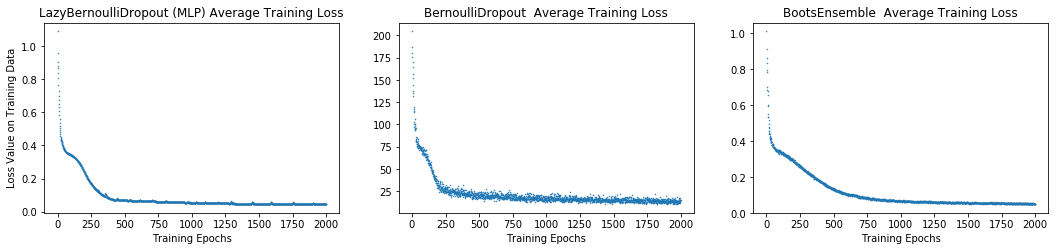

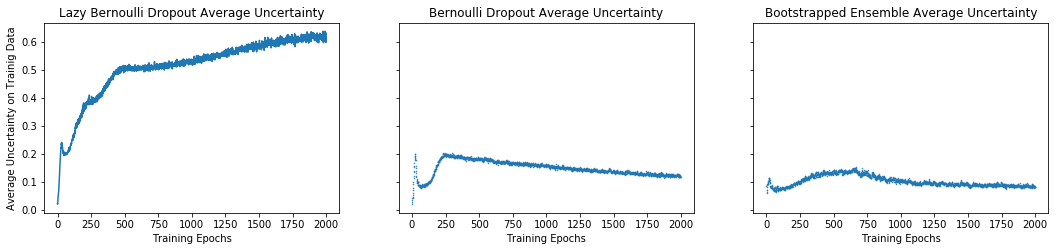

In [11]:
marker = '.'
markersize = 1

# Loss
f, axes = plt.subplots(1, 3)
f.set_figwidth(18)
f.set_figheight(3.5)

axes[0].plot(lazy_ber_drop_mlp_train_loss, marker, markersize=markersize)
axes[0].set_title('LazyBernoulliDropout (MLP) Average Training Loss')
axes[0].set_xlabel('Training Epochs')
axes[0].set_ylabel('Loss Value on Training Data')

axes[1].plot(ber_drop_mlp_train_loss, marker, markersize=markersize)
axes[1].set_title('BernoulliDropout  Average Training Loss')
axes[1].set_xlabel('Training Epochs')

axes[2].plot(boots_ensemble_train_loss, marker, markersize=markersize)
axes[2].set_title('BootsEnsemble  Average Training Loss')
axes[2].set_xlabel('Training Epochs')
f.savefig('./toy_example_loss_on_training_data.jpg', dpi=300)

# Uncertainty
f, axes = plt.subplots(1, 3, sharey=True)
f.set_figwidth(18)
f.set_figheight(3.5)

axes[0].plot(lazy_ber_drop_mlp_train_std, markersize=markersize)
axes[0].set_title('Lazy Bernoulli Dropout Average Uncertainty')
axes[0].set_xlabel('Training Epochs')
axes[0].set_ylabel('Average Uncertainty on Trainig Data')

axes[1].plot(ber_drop_mlp_train_std,marker, markersize=markersize)
axes[1].set_title('Bernoulli Dropout Average Uncertainty')
axes[1].set_xlabel('Training Epochs')

axes[2].plot(boots_ensemble_train_std, marker, markersize=markersize)
axes[2].set_title('Bootstrapped Ensemble Average Uncertainty')
axes[2].set_xlabel('Training Epochs')
f.savefig('./toy_example_uncertainty_on_training_data.jpg', dpi=300)

# Post Sampling to Estimate Uncertainty

In [12]:
x_test = np.arange(-1, 2, 0.005)
x_test = x_test.reshape(-1,1)
X_test = np.concatenate([x_test, x_test**2, x_test**3], axis=1)
X_test.shape

(600, 3)

In [13]:
# post sampling
mlp_postSamples = np.zeros([X_test.shape[0], BerDrop_n_post, y_dim])
ber_drop_mlp_postSamples = np.zeros([X_test.shape[0], BerDrop_n_post, y_dim])
lazy_ber_drop_mlp_postSamples = np.zeros([X_test.shape[0], BerDrop_n_post, y_dim])
boots_ensemble_postSamples = np.zeros([X_test.shape[0], BerDrop_n_post, y_dim])

for i in range(X_test.shape[0]):
    x = X_test[i,:]
    x_postSampling = np.matlib.repmat(x, BerDrop_n_post, 1) # repmat x for post sampling
    
    # MLP
    mlp_postSamples[i,:,:] = sess.run(mlp_y, feed_dict={x_ph: x_postSampling})
    
    # BernoulliDropoutMLP
    ber_drop_mlp_postSamples[i,:,:] = sess.run(ber_drop_mlp_y, feed_dict={x_ph: x_postSampling})
    
    # LazyBernoulliDropoutMLP
    sess.run(lazy_ber_drop_mlp_update) # copy weights
    lazy_ber_drop_mlp_postSamples[i,:,:] = sess.run(lazy_ber_drop_mlp_y, feed_dict={x_ph: x_postSampling})
    
    # BootstrappedEnsemble
    boots_ensemble_postSamples[i,:,:] = boots_ensemble.prediction(sess, x) 


In [14]:

mlp_mean = np.mean(mlp_postSamples,axis=1)
mlp_std = np.std(mlp_postSamples,axis=1)

ber_drop_mlp_mean = np.mean(ber_drop_mlp_postSamples,axis=1)
ber_drop_mlp_std = np.std(ber_drop_mlp_postSamples,axis=1)

lazy_ber_drop_mlp_mean = np.mean(lazy_ber_drop_mlp_postSamples,axis=1)
lazy_ber_drop_mlp_std = np.std(lazy_ber_drop_mlp_postSamples,axis=1)

boots_ensemble_mean = np.mean(boots_ensemble_postSamples,axis=1)
boots_ensemble_std = np.std(boots_ensemble_postSamples,axis=1)


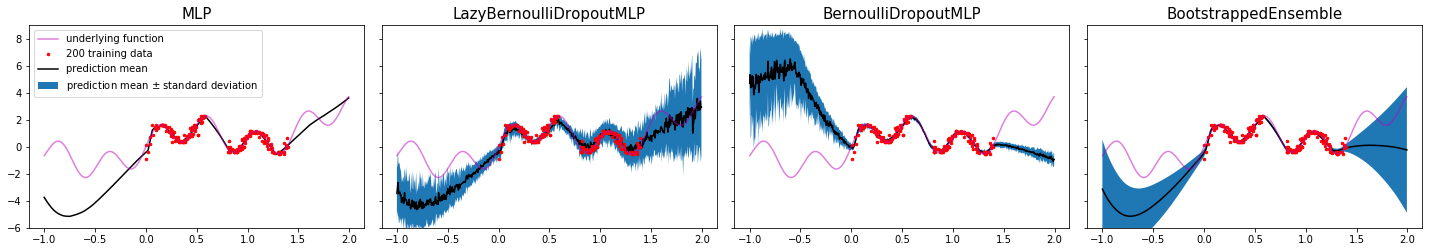

In [17]:
markersize = 5
f, axes = plt.subplots(1,4,sharey=True)
# f.suptitle('n_training_data={}, n_post_samples={}, dropout_rate={}, n_trainig_epochs={}, bootstrapp_p={}'.format(training_data_size, 
#                                                                                                                  BerDrop_n_post,
#                                                                                                                  dropout_rate,
#                                                                                                                  training_epoches,
#                                                                                                                  bootstrapp_p), 
#            fontsize=20)

f.set_figwidth(20)
f.set_figheight(4)

axes[0].plot(x_test, mlp_mean, 'k')
axes[0].plot(x_train, y_train, 'r.', markersize=markersize)
axes[0].plot(x_f, y_f,'m', alpha=0.5)
axes[0].fill_between(x_test.flatten(), 
                     (mlp_mean+mlp_std).flatten(), 
                     (mlp_mean-mlp_std).flatten())
axes[0].set_title('MLP', fontsize=15)

axes[1].plot(x_test, lazy_ber_drop_mlp_mean, 'k')
axes[1].plot(x_train, y_train, 'r.', markersize=markersize)
axes[1].plot(x_f, y_f,'m', alpha=0.5)
axes[1].fill_between(x_test.flatten(), 
                     (lazy_ber_drop_mlp_mean+lazy_ber_drop_mlp_std).flatten(), 
                     (lazy_ber_drop_mlp_mean-lazy_ber_drop_mlp_std).flatten())
# axes[1].fill_between(x_test.flatten(), 
#                      (lazy_ber_drop_mlp_mean+lazy_ber_drop_mlp_std/2).flatten(), 
#                      (lazy_ber_drop_mlp_mean-lazy_ber_drop_mlp_std/2).flatten())
axes[1].set_title('LazyBernoulliDropoutMLP', fontsize=15)

axes[2].plot(x_test, ber_drop_mlp_mean, 'k')
axes[2].plot(x_train, y_train, 'r.', markersize=markersize)
axes[2].plot(x_f, y_f,'m', alpha=0.5)
axes[2].fill_between(x_test.flatten(), 
                     (ber_drop_mlp_mean+ber_drop_mlp_std).flatten(), 
                     (ber_drop_mlp_mean-ber_drop_mlp_std).flatten())
axes[2].set_title('BernoulliDropoutMLP', fontsize=15)

prediction_mean_h, = axes[3].plot(x_test, boots_ensemble_mean, 'k')
training_data_h, = axes[3].plot(x_train, y_train, 'r.', markersize=markersize)
underlying_function_h, = axes[3].plot(x_f, y_f,'m', alpha=0.5)
prediction_std_h = axes[3].fill_between(x_test.flatten(), 
                     (boots_ensemble_mean+boots_ensemble_std).flatten(), 
                     (boots_ensemble_mean-boots_ensemble_std).flatten())
axes[3].set_title('BootstrappedEnsemble', fontsize=15)
axes[3].set_ylim(-6, 9)

axes[0].legend(handles=[underlying_function_h, training_data_h, prediction_mean_h, prediction_std_h],
               labels=['underlying function', '{} training data'.format(training_data_size), 'prediction mean', 'prediction mean $\pm$ standard deviation'])
plt.tight_layout()
f.subplots_adjust(top=0.8)
plt.savefig('./toy_example_comparison_of_uncertainty_estimation.jpg', dpi=300)